In [1]:
import pyccl as ccl
print(f"I am using pyccl version {ccl.__version__}")
import numpy as np
from scripts.data_vectors import DataVectors
from scripts.presets import Presets
import scripts.plotting as p
import matplotlib.pyplot as plt
from scripts.data_vector_metrics import DataVectorMetrics
import cmasher as cmr

I am using pyccl version 2.8.0


In [12]:
redshift_max = 3.5
redshift_resolution_1 = 300  # this is the first resolution of redshifts
redshift_resolution_2 = 5000  # this is the second resolution of redshifts
forecast_year = "10"
# Please note that the redshift resolution is the number of redshifts between 0 and redshift_max.
# Additionally, a lot of parametric sweeping is already coded into helper functions 
# so we will not need to worry about that for now.

# We will also investigate ell binning but for this particular exercise,
# we will keep the ell binning at default values.
#ell_min = 20
#ell_max = 2000
#n_ell = 50

# We now initialize the class by only passing the redshift information.
presets1 = Presets(redshift_max=redshift_max,
                  redshift_resolution=redshift_resolution_1,
                  forecast_year=forecast_year)
presets2 = Presets(redshift_max=redshift_max,
                    redshift_resolution=redshift_resolution_2,
                    forecast_year=forecast_year)

redshift1 = presets1.redshift_range
redshift2 = presets2.redshift_range

dv1 = DataVectors(presets1)
dv2 = DataVectors(presets2)
ells1 = dv1.ells
ells2 = dv2.ells

shear_cls_1 = dv1.cosmic_shear_cls(include_all_correlations=True)
shear_cls_2 = dv2.cosmic_shear_cls(include_all_correlations=True)

clu_cls_1 = dv1.galaxy_clustering_cls(include_all_correlations=True)
clu_cls_2 = dv2.galaxy_clustering_cls(include_all_correlations=True)

ggl_cls_1 = dv1.galaxy_galaxy_lensing_cls(include_all_correlations=True)
ggl_cls_2 = dv2.galaxy_galaxy_lensing_cls(include_all_correlations=True)

wl_kernel1 = dv1.get_wl_kernel()
wl_kernel2 = dv2.get_wl_kernel()

nc_kernel1 = dv1.get_nc_kernel()
nc_kernel2 = dv2.get_nc_kernel()

Data saved to data_output/angular_power_spectra/cosmic_shear_correlations_all_y10.npy
Data saved to data_output/angular_power_spectra/cosmic_shear_cls_all_y10_zmax3.5_zres300_ccl_v2.8.0.npy
Data saved to data_output/angular_power_spectra/cosmic_shear_correlations_all_y10.npy
Data saved to data_output/angular_power_spectra/cosmic_shear_cls_all_y10_zmax3.5_zres5000_ccl_v2.8.0.npy
Data saved to data_output/angular_power_spectra/galaxy_clustering_correlations_all_y10.npy
Data saved to data_output/angular_power_spectra/galaxy_clustering_cls_all_y10_zmax3.5_zres300_ccl_v2.8.0.npy
Data saved to data_output/angular_power_spectra/galaxy_clustering_correlations_all_y10.npy
Data saved to data_output/angular_power_spectra/galaxy_clustering_cls_all_y10_zmax3.5_zres5000_ccl_v2.8.0.npy
Data saved to data_output/angular_power_spectra/galaxy_galaxy_lensing_correlations_all_y10.npy
Data saved to data_output/angular_power_spectra/galaxy_galaxy_lensing_cls_all_y10_zmax3.5_zres300_ccl_v2.8.0.npy
Data saved

In [13]:
# Initialize DataVectorMetrics for both redshift resolutions
dvm1 = DataVectorMetrics(presets1)
dvm2 = DataVectorMetrics(presets2)

# Compute chi-squared differences using both methods
delta_chi2_method_1 = dvm1.get_delta_chi2(cls_gc=clu_cls_1, cls_ggl=ggl_cls_1, cls_cs=shear_cls_1,
                                          cls_gc_ref=clu_cls_2, cls_ggl_ref=ggl_cls_2, cls_cs_ref=shear_cls_2)

delta_chi2_method_2 = dvm1.get_delta_chi2robert(cl_gc=clu_cls_1, cl_ggl=ggl_cls_1, cl_cs=shear_cls_1,
                                                cl_gc_1=clu_cls_2, cl_ggl_1=ggl_cls_2, cl_cs_1=shear_cls_2)

# Check if results are consistent
print("Delta Chi-squared (New Method):", delta_chi2_method_1)
print("Delta Chi-squared (Robert's Method):", delta_chi2_method_2)

# Compare the results
difference = np.abs(delta_chi2_method_1 - delta_chi2_method_2)
print("Difference between methods:", difference)


Delta Chi-squared (New Method): 0.0003915179307875744
Delta Chi-squared (Robert's Method): 0.0003915179307875744
Difference between methods: 0.0


In [14]:
%%time
kernel_sweep = dvm1.kernel_peaks_z_resolution_sweep()

CPU times: user 4min 40s, sys: 27.1 s, total: 5min 7s
Wall time: 53.3 s


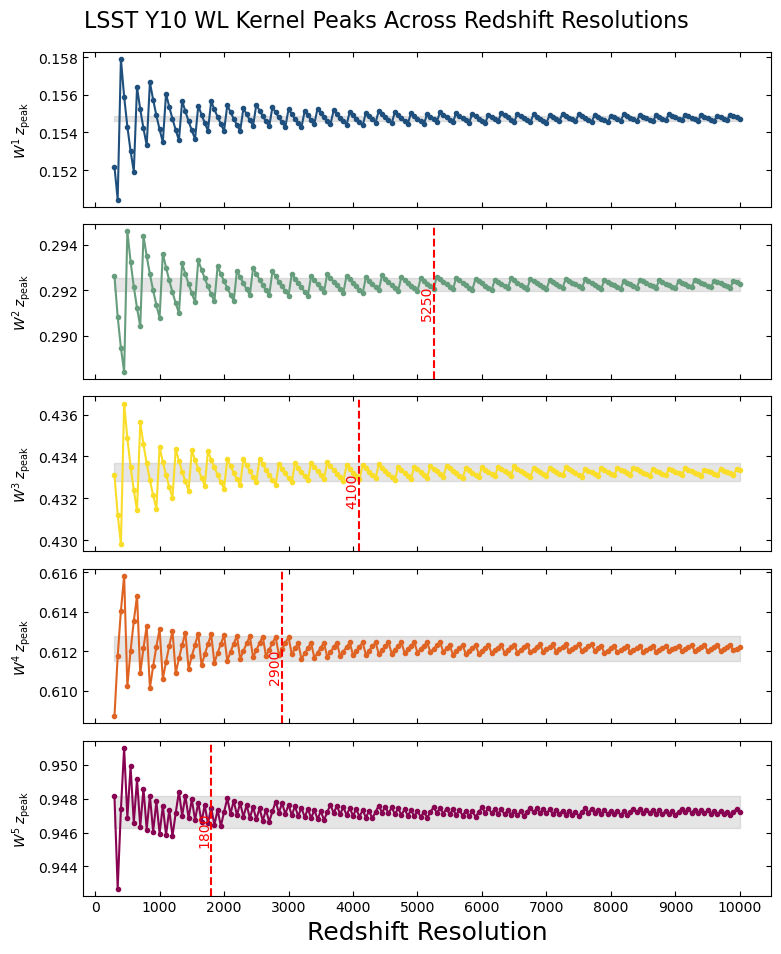

In [16]:
p.plot_kernel_peaks_z_resolution(kernel_sweep,
                                 forecast_year,
                                 kernel_type="wl",
                                 percentage=0.1,
                                 stability_steps=10, )


IndexError: list index out of range

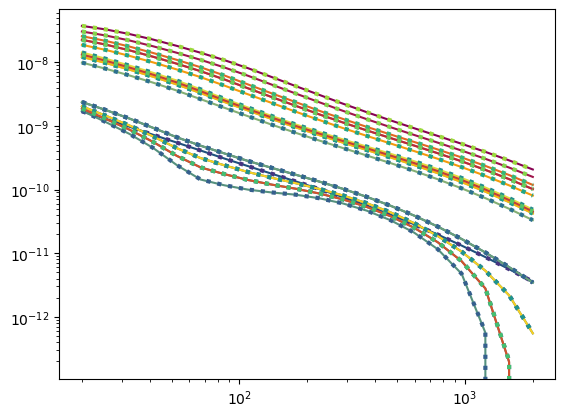

In [10]:
p.compare_two_data_vector_sets_absolute(shear_cls_1, shear_cls_2, ells1, ells2)

In [ ]:
p.compare_two_data_vector_sets_relative(shear_cls_1,
                                        shear_cls_2,
                                        ells1,
                                        label_1=f"$n_z={redshift_resolution_1}$", 
                                        label_2=f"$n_z={redshift_resolution_2}$")

In [ ]:
p.compare_two_data_vector_sets_relative(clu_cls_1,
                                        clu_cls_2,
                                        ells1,
                                        label_1=f"$n_z={redshift_resolution_1}$",
                                        label_2=f"$n_z={redshift_resolution_2}$")